In [1]:
# READ REFERENCE --> https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab

In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import pymc3 as pm

import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std
from sklearn.model_selection import train_test_split

config = get_config()
train_df = pd.read_csv(config['data_path']+'/train.csv')
test_df = pd.read_csv(config['data_path']+'/test.csv')

In [3]:
def encode_categorical(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus'],1,inplace=True)

    return df

In [4]:
# Getting the data ready

train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)
patients_train, patients_test = train_test_split(np.unique(train_df['Patient'].values), test_size=0.3, shuffle=True, random_state=63)

df_train = []
for p in patients_train:
    mask = train_df['Patient'] == p
    df_train.append(train_df.values[mask])
df_train = pd.DataFrame(np.concatenate(df_train, 0), columns=list(train_df.columns))

df_test = []
for p in patients_test:
    mask = train_df['Patient'] == p
    df_test.append(train_df.values[mask])
df_test = pd.DataFrame(np.concatenate(df_test, 0), columns=list(train_df.columns))

# Normalizing data
mu_norm = dict()
std_norm = dict()

for feat in ['Weeks', 'FVC', 'Percent', 'Age']:
    mu_norm[feat], std_norm[feat] = np.mean(df_train[feat].values), np.std(df_train[feat].values)
    df_train[feat] = (df_train[feat].values - mu_norm[feat])/std_norm[feat]
    df_test[feat] = (df_test[feat].values - mu_norm[feat])/std_norm[feat]

pats_train = df_train['Patient'].values
pats_test = df_test['Patient'].values

X_train = df_train.drop(['Patient', 'FVC'], 1)
cols_X = X_train.columns
X_train = X_train.values.astype(np.float32)
Y_train = df_train['FVC'].values.astype(np.float32)
X_test = df_test.drop(['Patient', 'FVC'], 1).values.astype(np.float32)
Y_test = df_test['FVC'].values.astype(np.float32)

In [12]:
class BayesianLR:
    def __init__(self):
        pass

    def predict(self, X, n_samples):
        Y = np.zeros((X.shape[0], n_samples))

        for i in tqdm(range(n_samples)):
            sigma = np.random.choice(self.params['sigma'])
            inter = np.random.choice(self.params['Intercept'])
            x_coeff = []
            for i in range(X.shape[1]):
                x_coeff.append(np.random.choice(self.params['x_coeff_'+str(i)]))
            x_coeff = np.array(x_coeff)

            Y_mu = inter + np.dot(X, x_coeff)
            Y[:,i] = norm(Y_mu, sigma).rvs(Y_mu.shape[0])

        return Y

    def fit(self, X, Y):
        with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
            # Define priors
            sigma = pm.HalfNormal('sigma', sigma=10)
            intercept = pm.Normal('Intercept', 0, sigma=20)

            mu = intercept
            
            for i in range(X.shape[1]):
                x_coeff = pm.Normal('x_coeff_'+str(i), 0, sigma=20)
                mu += X[:,i] * x_coeff

            # Define likelihood
            likelihood = pm.Normal('y', mu=mu , sigma=sigma, observed=Y)

            # Inference!
            self.trace = pm.sample(draws=2000, target_accept=0.95, max_treedepth=100, cores=2)

            # Store results
            self.params = dict()
            for x in self.trace.varnames[1:]:    
                self.params[x] = trace.get_values(x)
            

In [13]:
regr = BayesianLR()
regr.fit(X_train, Y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_coeff_6, x_coeff_5, x_coeff_4, x_coeff_3, x_coeff_2, x_coeff_1, x_coeff_0, Intercept, sigma]


&lt;IPython.core.display.HTML object&gt;

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1739 seconds.


NameError: name &#39;trace&#39; is not defined

In [167]:
Y_pred_tr = np.mean(regr.predict(X_train),1)
Y_pred = np.mean(regr.predict(X_test),1)

print('Training Error', np.mean(np.square(Y_train - Y_pred_tr )))
print('Test Error', np.mean(np.square(Y_test - Y_pred )))

Training Error 0.16626465113363897
Test Error 0.2407009649274396


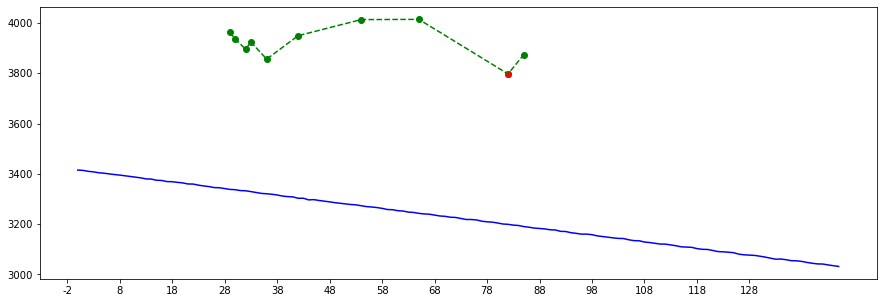

Competition metric -7.482053411890959


In [168]:
id_pat = np.random.randint(X_test.shape[0])
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_test[id_pat:id_pat+1, 1:], 146, axis=0)])
Y_pred = regr.predict_proba(X_pred, 100000)

mask = df_test['Patient'] == pats_test[id_pat]
test_vals = df_test[['Patient', 'Weeks', 'FVC']].values[mask,1:]

plt.figure(figsize=(15,5))
plt.plot((np.mean(Y_pred,1)*std_norm['FVC'])+mu_norm['FVC'], linestyle='-', c='b')
#plt.plot((np.mean(Y_pred,1)*std_norm['FVC'])+mu_norm['FVC']+(np.std(Y_pred,1)*std_norm['FVC']+mu_norm['FVC']), linestyle='--', c='b')
#plt.plot((np.mean(Y_pred,1)*std_norm['FVC'])+mu_norm['FVC']-(np.std(Y_pred,1)*std_norm['FVC']+mu_norm['FVC']), linestyle='--', c='b')

plt.xticks(range(-12,134, 10), range(-12,134, 10))
plt.scatter((test_vals[:,0]*std_norm['Weeks'])+mu_norm['Weeks'], (test_vals[:,1]*std_norm['FVC'])+mu_norm['FVC'], c='g')
plt.plot((test_vals[:,0]*std_norm['Weeks'])+mu_norm['Weeks'], (test_vals[:,1]*std_norm['FVC'])+mu_norm['FVC'], linestyle='--', c='g')

plt.scatter((X_test[id_pat:id_pat+1, 0]*std_norm['Weeks'])+mu_norm['Weeks'], (Y_test[id_pat:id_pat+1]*std_norm['FVC'])+mu_norm['FVC'], c='r')
plt.show()

Y_pred_comp = (regr.predict_proba(X_test, 100000)*std_norm['FVC'])+mu_norm['FVC']
Y_true = (Y_test*std_norm['FVC'])+mu_norm['FVC']

print('Competition metric', np.mean(competition_metric(Y_true, np.mean(Y_pred_comp,1), np.std(Y_pred_comp,1))))

In [ ]:
# Generate competition submission

submission = []

for i in range(test_df.shape[0]):
    patient = test_df.values[i,0]
    X_pred = test_df[cols_X].iloc[i:i+1,:]

    for feat in ['Weeks', 'Percent', 'Age']:
        X_pred[feat] = (X_pred[feat].values - mu_norm[feat])/std_norm[feat]
    X_pred = X_pred.values.reshape(1,-1)

    X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_pred[:, 1:], 146, axis=0)])
    Y_pred = (lin_reg.predict(X_pred)*std_norm['FVC'])+mu_norm['FVC']

    patient_submission = []
    for j, w in enumerate(np.arange(-12,134)):
        vals = np.array([w, patient+'_'+str(w), Y_pred[j], (std_linreg*std_norm['FVC'])+mu_norm['FVC']]).reshape(1,-1)
        vals = pd.DataFrame(vals, columns=['Week', 'Patient_Week', 'FVC', 'Confidence'])
        vals['Week'] = vals['Week'].astype(np.int32)
        vals['FVC'] = vals['FVC'].astype(np.float32)
        vals['Confidence'] = vals['Confidence'].astype(np.float32)
        patient_submission.append(vals)
    patient_submission = pd.concat(patient_submission)
    submission.append(patient_submission)

submission = pd.concat(submission)
submission.sort_values('Week', inplace=True)
submission.drop(['Week'], 1, inplace=True)

submission.head()
submission.to_csv('submission.csv', index=False)